In [1]:
import rasterio
import fiona
from rasterio import Affine as A
from rasterio.warp import calculate_default_transform, reproject, Resampling
import rasterio.features
import geopandas as gpd
from shapely.geometry import shape
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


In [2]:
gdf = gpd.read_file('../points_defor/points_grid.shp')
years = [2005,2006,2007,2008,2009,2010,2011]


# Define the function
def check_point(row):
    # Get the row and column of the point in the raster
    row, col = src.index(row.geometry.x, row.geometry.y)
    
    # Check if the point overlays a pixel of 1
    if raster_array[row, col] == 1:
        return True
    else:
        return False
for year in years:
    image = f"../classification/reclassified/reclassif_filter_{year}.tif"
    with rasterio.open(image) as src:
        raster_array = src.read(1)
    gdf[f'overlays_{year}'] = gdf.apply(check_point, axis=1)

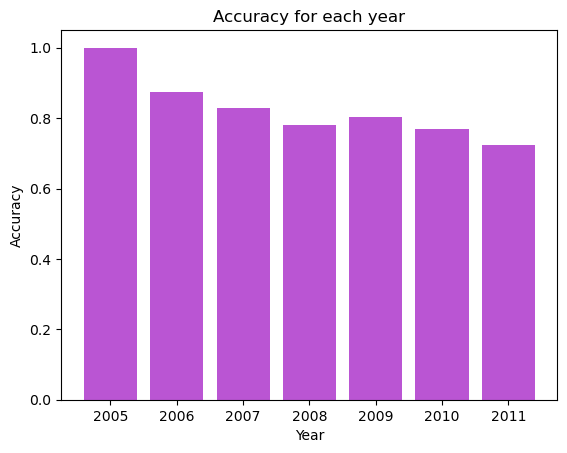

<Figure size 640x480 with 0 Axes>

In [8]:
validation =  gdf.iloc[:, 8:]
validation['deforestat']
overlays_columns = validation.filter(like='overlays_')
result = ~overlays_columns.any(axis=1)

df = pd.concat([gdf['fid'],validation['deforestat'], overlays_columns], axis=1)
df['fid'] = df['fid'].astype(int)
overlays = df.filter(like='overlays_')
df[overlays.columns] = overlays.map(lambda x: 1 if x else 0)
for year in years:
    df[f'true_{year}'] = df['deforestat'].apply(lambda x: 1 if x <= year and x != 0 else 0)

accuracy_dict = {}
for year in years:
    y_true = df[f'true_{year}']
    y_pred = df[f'overlays_{year}']
    conf_matrix = confusion_matrix(y_true, y_pred)
    acx = accuracy_score(y_true, y_pred)
    accuracy_dict[year] = acx

# Create bar graph
plt.bar(accuracy_dict.keys(), accuracy_dict.values(),color='#BA55D3')
plt.xlabel('Year')
plt.ylabel('Accuracy')
plt.title('Accuracy for each year')
plt.show()
plt.savefig('plot.png', transparent=True)

In [4]:
df_2011 = df[['fid','true_2011','overlays_2011']]
df_2011['diff'] = ((df_2011['true_2011'] == 1) & (df_2011['overlays_2011'] == 0)).astype(int)

df_2011

/var/folders/3q/vbmvllns40b4bvjdkg7v7lkh0000gn/T/ipykernel_54637/1498544045.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2011['diff'] = ((df_2011['true_2011'] == 1) & (df_2011['overlays_2011'] == 0)).astype(int)


,fid,true_2011,overlays_2011,diff
0,35,0,0,0
1,36,0,0,0
2,51,0,0,0
3,52,0,1,0
4,122,0,0,0
...,...,...,...,...
82,349,1,1,0
83,357,1,1,0
84,365,1,1,0
85,369,0,0,0


In [5]:
merged_df = gdf.merge(df_2011, on='fid', how='inner')
#merged_df.to_file("../points_defor/difference2011.gpkg", driver="GPKG")

In [6]:
merged_df['fid'] = merged_df['fid'].astype(int)
merged_df.to_file("merged_df.gpkg", driver="GPKG")

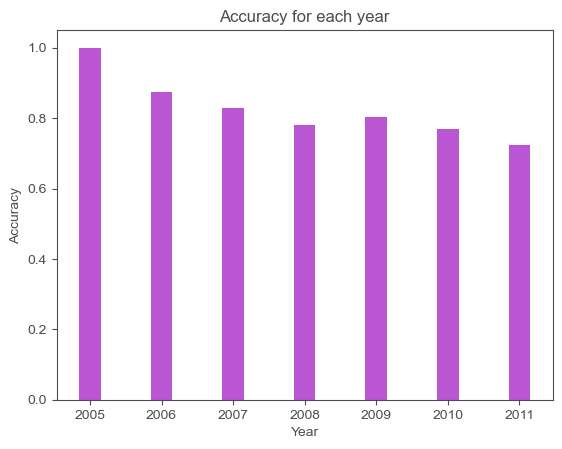

In [42]:
import matplotlib as mpl

mpl.rc('font', family='Arial')
mpl.rc('xtick', labelcolor='#4D4D4D')
mpl.rc('ytick', labelcolor='#4D4D4D')

fig, ax = plt.subplots()
#plt.minorticks_on()
#plt.grid(which='minor', linestyle='-', linewidth='0.5', color='grey')
ax.bar(accuracy_dict.keys(), accuracy_dict.values(), color='#BA55D3',width=0.3)
plt.xlabel('Year', color='#4D4D4D')
plt.ylabel('Accuracy', color='#4D4D4D')
plt.title('Accuracy for each year', color='#4D4D4D')
for spine in ax.spines.values():
    spine.set_color('#4D4D4D')
ax.tick_params(colors='#4D4D4D')

plt.savefig('accuracy.png', transparent=True)

#plt.savefig('plot.png', transparent=True)

In [14]:
accuracy_dict

{2005: 1.0,
 2006: 0.8735632183908046,
 2007: 0.8275862068965517,
 2008: 0.7816091954022989,
 2009: 0.8045977011494253,
 2010: 0.7701149425287356,
 2011: 0.7241379310344828}